# 0. Imports

In [1]:
#The code of "SFE: A Simple, Fast and Efficient Feature Selection Algorithm for High-Dimensional Data"
#IEEE Transactions on Evolutionary Computation: doi: https://doi.org/10.1109/TEVC.2023.3238420
#Autor:Behrouz Ahadzadeh
#Email: b.ahadzade@yahoo.com

In [2]:
dataset_name = 'tcga-brca-rs42-gexcna-2000x2000-minmaxscaler-xai'
deepssc_model_name = 'new-ssc'
COHORT = 'TCGA_BRCA_RS42_GExCNA_2000x2000_MinMaxScaler'

## Phase 1

In [3]:
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from numpy.random import rand, seed, randint
import pandas as pd
from IPython.display import display, HTML
!pip install watermark --quiet
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import math

## Phase 2

In [4]:
from scipy.stats import mode
from datetime import datetime

!pip install captum --quiet
from captum.attr import IntegratedGradients

## Phase 3

In [5]:
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import copy
from sklearn.compose import ColumnTransformer 
from IPython.display import Markdown

import warnings
from sklearn.exceptions import ConvergenceWarning

# 1.0. Hyperparameters

In [6]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

rseed = 42
set_seed(rseed)

Random seed set as 42


In [7]:
postfix_tr = '_tr'
postfix_te = '_val'

data_folder = f'/kaggle/input/{dataset_name}/{COHORT}'
main_deepssc = f'/kaggle/input/{deepssc_model_name}/main.py'
model_folder = '/kaggle/working/models'

In [8]:
num_models = 5

In [9]:
# Subtypes
loc_file_json_id_omic = data_folder + '/1/dct_index_subtype.json'
with open(loc_file_json_id_omic) as file_json_id_omic:
    dct_LABEL_MAPPING_NAME = json.load(file_json_id_omic)
    # dct_LABEL_MAPPING_NAME = {int(k): v for k,v in dct_LABEL_MAPPING_NAME.items()} # convert str number key to int
LABEL_MAPPING_NAME = dct_LABEL_MAPPING_NAME.values()

num_subtypes = len(LABEL_MAPPING_NAME)
view_list = [1, 2]

In [10]:
# Check data size
for fold_id in [3]:
#     print(f'idx data: {fold_id}')
    tmp = list(LABEL_MAPPING_NAME)
    label_files = ['tr', 'te', 'val']
    dict = {
        'tr': 'Train set',
        'te': 'Test set',
        'val': 'Validation set'
    }
    
    for label_file in label_files:
        df = pd.read_csv(f'{data_folder}/{fold_id}/labels_{label_file}.csv', header=None, names=['featname'])
        feature_counts = df['featname'].value_counts().sort_index()
        
        print(f'{dict[label_file]}')
        
        res = {}
        for feature, count in feature_counts.items():
            res[tmp[feature]] = count

        print(pd.DataFrame(res, index=[0]).to_string(index=False), '\n')
    
    print('\nCount Samples: \n')
    for idx in view_list:
        res = {}
        for label_file in label_files:
            df = pd.read_csv(f'{data_folder}/{fold_id}/{idx}_{label_file}.csv', header=None, names=['featname'])
            res[dict[label_file]] = df.shape[0]
        
        try:
            unlabeled_df = pd.read_csv(f'{data_folder}/{fold_id}/{idx}_unlabeled.csv', header=None, names=['featname'])
            res['Unlabeled Set'] = unlabeled_df.shape[0]
        except:
            print(f'No unlabel data found!')
            
        print(pd.DataFrame(res, index=[0]).to_string(index=False), '\n')

Train set
 Basal  Her2  LumA  LumB  Normal
    85    43   262   119      15 

Test set
 Basal  Her2  LumA  LumB  Normal
    27    13    82    38       4 

Validation set
 Basal  Her2  LumA  LumB  Normal
    22    11    65    30       3 


Count Samples: 

No unlabel data found!
 Train set  Test set  Validation set
       524       164             131 

No unlabel data found!
 Train set  Test set  Validation set
       524       164             131 



# 1.1. TRAINING

In [11]:
from sklearn import svm
def fit_eval(xtrain, ytrain, xtest, ytest, kk):
    if len(kk) == 0:
        kk = randint(1, np.size(xtrain, 1))
    # print(sf)
    
    sf = [i for i in range(np.size(xtrain, 1)) if kk[i] == 1]
    pos = np.transpose(sf)

    model = svm.SVC()
    Xtrain = xtrain[:, pos]
    Xtest = xtest[:, pos]
    
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)

    return f1_score(ypred, ytest, average='macro') * 100

def fit_all(xtrain, ytrain, xtest, ytest, kk):
    res = []
    for i in range(len(xtrain)):
        res.append(fit_eval(xtrain[i], ytrain[i], xtest[i], ytest[i], kk))

    return np.array(res).mean()

def fit_all_print(xtrain, ytrain, xtest, ytest, kk):
    res = []
    for i in range(len(xtrain)):
        res.append(fit_eval(xtrain[i], ytrain[i], xtest[i], ytest[i], kk))
    print(res)

    print(np.array(res).mean())

In [12]:
# Hàm cập nhật vận tốc và vị trí của các particle
def update_velocity_position(x, v, pbest, gbest, w=0.5, c1=1.5, c2=1.5):
    r1 = np.random.rand()
    r2 = np.random.rand()
    v_new = w * v + c1 * r1 * (pbest - x) + c2 * r2 * (gbest - x)
    x_new = np.where(np.random.rand(len(x)) < sigmoid(v_new), 1, 0)
    return x_new, v_new

In [13]:
def PSO1(nParticles, Max_FEs, EFs, Run, Xtrain, ytrain, Xval, yval, Xtest, ytest, Cost_tr, Cost_va, Cost_te, FN):
    # Hàm sigmoid
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    E = EFs
    nVar = Xtrain[0].shape[1]  # Number of Decision Variables
    VarSize = (1, nVar)    # Size of Decision Variables Matrix

    # PSO Parameters
    VarMin = -3            # Lower Bound of Variables
    VarMax = 3             # Upper Bound of Variables
    lu_v = 3 * np.array([-np.ones(nVar), np.ones(nVar)])

    nPop = nParticles              # Population Size (Swarm Size)
    w = 0.7
    c1 = 1.5              # Personal Learning Coefficient
    c2 = 1.5                # Global Learning Coefficient

    # Particle Initialization
    class Particle:
        def __init__(self):
            self.Position = None
            self.Cost = None
            self.Velocity = None
            self.Best = {'Position': None, 'Cost': None}

    particle = [Particle() for _ in range(nPop)]
    GlobalBest = {'Position': None, 'Cost': 0}

    for i in range(nPop):
        particle[i].Velocity = np.random.uniform(VarMin, VarMax, VarSize)

    for i in range(nVar):
        particle[0].Velocity[0, i] = 3
        particle[0].Position = np.ones(VarSize)
    particle[0].Cost = fit_all(Xtrain, ytrain, Xval, yval, particle[0].Position[0])

    for i in range(1, nPop):
        SS = sigmoid(particle[i].Velocity)
        R = np.random.rand(*VarSize)
        particle[i].Position = (R < SS).astype(int)
        particle[i].Cost = fit_all(Xtrain, ytrain, Xval, yval, particle[i].Position[0])

        # Update Personal Best
        particle[i].Best['Position'] = particle[i].Position
        particle[i].Best['Cost'] = particle[i].Cost

        # Update Global Best
        if particle[i].Best['Cost'] > GlobalBest['Cost']:
            GlobalBest = particle[i].Best

    particle[0].Best['Position'] = particle[0].Position
    particle[0].Best['Cost'] = particle[0].Cost
    
    Fit_tr = fit_all(Xtrain, ytrain, Xtrain, ytrain, particle[0].Position[0])
    GlobalBest = particle[0].Best
    Fit_te = fit_all(Xtrain, ytrain, Xtest, ytest, particle[0].Position[0])

    # PSO Main Loop
    while EFs <= Max_FEs:
        EFs += nPop

        for i in range(nPop):
            # Update Velocity
            particle[i].Velocity = (w * particle[i].Velocity +
                                    c1 * np.random.rand(*VarSize) * (particle[i].Best['Position'] - particle[i].Position) +
                                    c2 * np.random.rand(*VarSize) * (GlobalBest['Position'] - particle[i].Position))

            V_u = lu_v[1, :]
            particle[i].Velocity = np.clip(particle[i].Velocity, -V_u, V_u)

            # Update Position
            SS = sigmoid(particle[i].Velocity)
            R = np.random.rand(*VarSize)
            particle[i].Position = (R < SS).astype(int)

            # Evaluation
            particle[i].Cost = fit_all(Xtrain, ytrain, Xval, yval, particle[i].Position[0])

            # Update Personal Best
            if particle[i].Cost > particle[i].Best['Cost']:
                particle[i].Best['Position'] = particle[i].Position
                particle[i].Best['Cost'] = particle[i].Cost

                # Update Global Best
                if particle[i].Best['Cost'] > GlobalBest['Cost']:
                    Fit_tr = fit_all(Xtrain, ytrain, Xtrain, ytrain, particle[i].Position[0])
                    GlobalBest = particle[i].Best
                    Fit_te = fit_all(Xtrain, ytrain, Xtest, ytest, particle[i].Position[0])
            
            if E >= Max_FEs:
                break
            Cost_tr[E, Run - 1] = Fit_tr
            Cost_va[E, Run - 1] = GlobalBest['Cost']
            Cost_te[E, Run - 1] = Fit_te
            E += 1

        # Cost_val[E:E + nPop, Run - 1] = GlobalBest['Cost']

        print(f"SFE-PSO : Function Evaluation: {EFs} F1-macro = {GlobalBest['Cost']} "
              f"Number of Selected Features = {np.sum(GlobalBest['Position'])} Run: {Run}")

        # E += nPop

    FN[Run - 1, 0] = np.sum(GlobalBest['Position'])
    return Cost_tr, Cost_va, Cost_te, FN, GlobalBest['Position'][0]


In [14]:
def get_data(fold_id, file : str):
    return pd.read_csv(f'{data_folder}/{fold_id}/{file}.csv', delimiter=",", header=None)

feat1 = get_data(1, '1_featname')
feat2 = get_data(1, '2_featname')
feat = np.concatenate((feat1, feat2), axis=0)

Xtrain = []
Xval = []
Xtest = []

ytrain = []
yval = []
ytest = []

for i in range(1, num_models+1):
    inp = np.concatenate((get_data(i, '1_tr'), get_data(i, '2_tr')), axis=1)
    print(inp.shape)
    Input = np.asarray(inp)
    Input = stats.zscore(Input)

    tar = get_data(i, 'labels_tr')
    Target = np.asarray(tar)
           
    Xtrain.append(Input)
    ytrain.append(Target)
           
    inp = np.concatenate((get_data(i, '1_val'), get_data(i, '2_val')), axis=1)
    print(inp.shape)
    Input = np.asarray(inp)
    Input = stats.zscore(Input)

    tar = get_data(i, 'labels_val')
    Target = np.asarray(tar)
           
    Xval.append(Input)
    yval.append(Target)
           
    inp = np.concatenate((get_data(i, '1_te'), get_data(i, '2_te')), axis=1)
    print(inp.shape)
    Input = np.asarray(inp)
    Input = stats.zscore(Input)

    tar = get_data(i, 'labels_te')
    Target = np.asarray(tar)
           
    Xtest.append(Input)
    ytest.append(Target)

(524, 4000)
(131, 4000)
(164, 4000)
(524, 4000)
(131, 4000)
(164, 4000)
(524, 4000)
(131, 4000)
(164, 4000)
(524, 4000)
(131, 4000)
(164, 4000)
(524, 4000)
(131, 4000)
(164, 4000)


In [15]:
cnt_feat = 400
Max_FEs = 1000
Max_Run = 20

UR = 0.3
UR_Max = 0.3
UR_Min = 0.001
Run = 1

Best_Score = 0
Best_X = None
Cost_tr = np.full([Max_FEs, Max_Run], np.nan)
Cost_va = np.full([Max_FEs, Max_Run], np.nan)
Cost_te = np.full([Max_FEs, Max_Run], np.nan)
Sel_feat = np.full([Max_FEs, Max_Run], np.nan)
FN = np.zeros([Max_Run, 1])
Fit_X = 0

w = 0.5   # inertia weight
c1 = 1.5  # cognitive parameter
c2 = 1.5  # social parameter
n_particles=30 # the number of particles

while Run <= Max_Run:
    EFs = 1

    X = np.random.randint(1, 2, np.size(Input, 1))   # Initialize an Individual X
    Fit_tr = fit_all(Xtrain, ytrain, Xtrain, ytrain, X)    # Calculate the Fitness of X
    Fit_X = fit_all(Xtrain, ytrain, Xval, yval, X)    # Calculate the Fitness of X
    Fit_te = fit_all(Xtrain, ytrain, Xtest, ytest, X)    # Calculate the Fitness of X
    Nvar = np.size(Input, 1)                         # Number of Features in Dataset

    while EFs <= Max_FEs:
        """*************************SFE Algorithm**********************************"""
        X_New = np.copy(X)

        # Non-selection operation:
        U_Index = np.where(X == 1)                      # Find Selected Features in X
        NUSF_X = np.size(U_Index, 1)                    # Number of Selected Features in X
        UN = math.ceil(UR * Nvar)                         # The Number of Features to Unselect: Eq(2)
        K1 = np.random.randint(0, NUSF_X, UN)           # Generate UN random number between 1 to the number of selected features in X
        res = np.array([*set(K1)])
        res1 = np.array(res)
        K = U_Index[0][[res1]]                          # K=index(U)
        X_New[K] = 0                                    # Set X_New (K)=0 

       # Selection operation:
        if np.sum(X_New) < cnt_feat:
            S_Index = np.where(X_New == 0)              # Find non-selected Features in X
            NSF_X = np.size(S_Index, 1)                 # Number of non-selected Features in X
            SN = cnt_feat - np.sum(X_New)               # The Number of Features to Select
            res = np.random.choice(np.arange(NSF_X), size=SN, replace=False)        # Generate SN random number between 1 to the number of non-selected features in X
            res1 = np.array(res)
            K = S_Index[0][[res1]]
#                 X_New = np.copy(X)
            X_New[K] = 1                                # Set X_New (K)=1

        Fit_X_New = fit_all(Xtrain, ytrain, Xval, yval, X_New) # Calculate the Fitness of X_New

        if Fit_X_New > Fit_X:
            X = np.copy(X_New)
            Fit_X = Fit_X_New
            Fit_tr = fit_all(Xtrain, ytrain, Xtrain, ytrain, X_New)
            Fit_te = fit_all(Xtrain, ytrain, Xtest, ytest, X_New)

        UR = (UR_Max - UR_Min) * ((Max_FEs - EFs) / Max_FEs) + UR_Min  # Eq(3)
        Cost_tr[EFs-1, Run-1] = Fit_tr
        Cost_va[EFs-1, Run-1] = Fit_X
        Cost_te[EFs-1, Run-1] = Fit_te
        Sel_feat[EFs-1, Run-1] = np.sum(X)

        if EFs % 100 == 0:
            print('SFE - Iteration = {} :   F1-Score = {} :   Number of Selected Features= {} :  Run= {}'.format( EFs, Fit_X, np.sum(X), Run))
        
        EFs += 1

        if Fit_X > Best_Score:
            Best_Score = Fit_X
            Best_X = X
            
        """*************************PSO Algorithm**********************************"""
        # if EFs > 500 and EFs <= Max_FEs and (Cost_va[EFs-2,Run-1] - Cost_va[EFs-102,Run-1]) < 1e-2:
        #     """S = removing unselected features from the training dataset"""
        #     S = np.array([i for i in range(len(X)) if X[i] == 1])
        #     Xtrain_selected = [x[:, S] for x in Xtrain]
        #     Xval_selected = [x[:, S] for x in Xval]
        #     Xtest_selected = [x[:, S] for x in Xtest]
            
        #     Cost_tr, Cost_va, Cost_te, FN, gbest = PSO1(30, Max_FEs, EFs, Run, Xtrain_selected, ytrain, Xval_selected, yval, Xtest_selected, ytest, Cost_tr, Cost_va, Cost_te, FN)
        #     gbest_fitness = FN[Run - 1, 0]
        #     EFs = Max_FEs + 1
                
        #     if gbest_fitness > Best_Score:
        #         Best_Score = gbest_fitness
        #         Best_X = np.zeros(len(X))
        #         cnt = 0
        #         for i in range(len(X)):
        #             if X[i] == 1:
        #                 if gbest[cnt] == 1:
        #                     Best_X[i] = 1
        #                 cnt += 1
                        
    Run += 1

SFE - Iteration = 100 :   F1-Score = 77.72322698019869 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 200 :   F1-Score = 77.72322698019869 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 300 :   F1-Score = 77.72322698019869 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 400 :   F1-Score = 77.72322698019869 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 500 :   F1-Score = 78.14760571500638 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 600 :   F1-Score = 78.57768980819029 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 700 :   F1-Score = 78.57768980819029 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 800 :   F1-Score = 78.57768980819029 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 900 :   F1-Score = 79.12362296138792 :   Number of Selected Features= 400 :  Run= 1
SFE - Iteration = 1000 :   F1-Score = 80.86151141216574 :   Number of Selected Fea


 Fitness evaluate on Test:

 Best = 80.97392539695798 

 Count = 400 

 Mean = 78.9105198398183 

 Worst = 75.48924947808231  

 std  = 1.4753292333814108


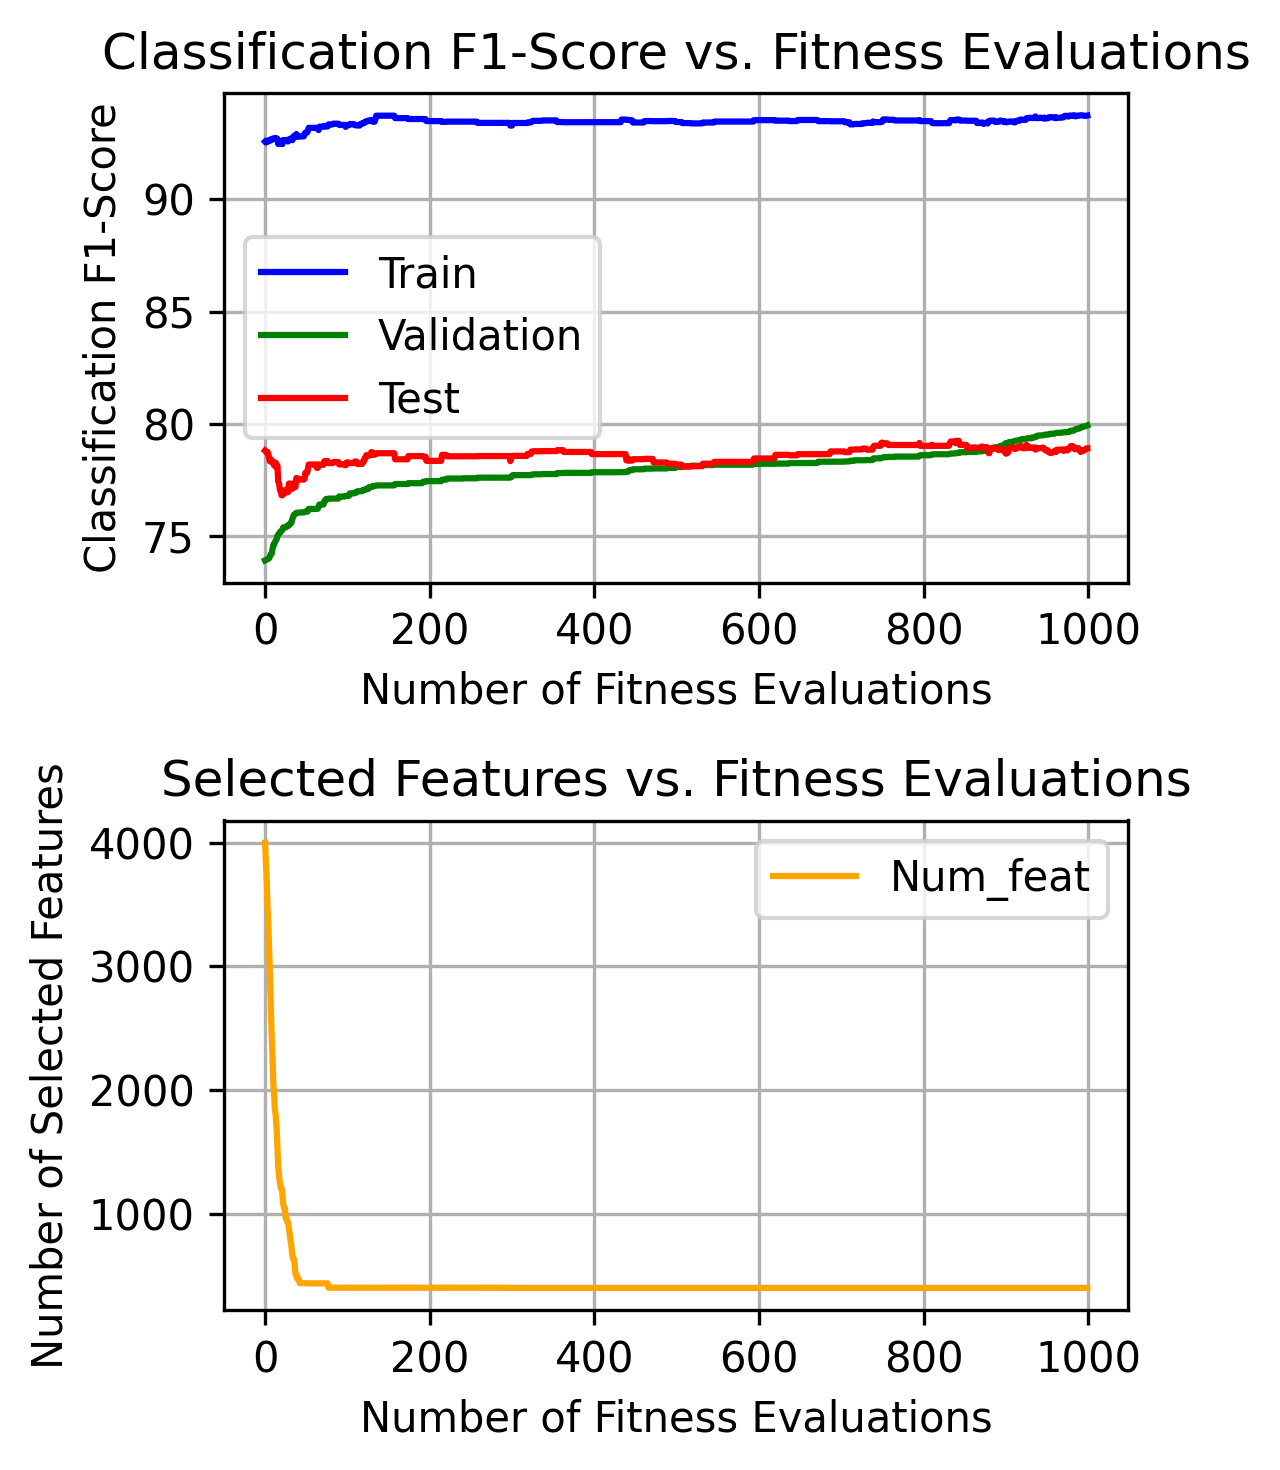

In [16]:
# Function to get the last non-NaN value in each column
def get_last_valid_per_column(matrix):
    last_valid_values = np.full(matrix.shape[1], np.nan)  # Initialize with NaN
    for col in range(matrix.shape[1]):
        valid_indices = np.where(~np.isnan(matrix[:, col]))[0]  # Get indices of non-NaN values
        if valid_indices.size > 0:
            last_valid_values[col] = matrix[valid_indices[-1], col]  # Get the last valid value
    return last_valid_values

# Get the last non-NaN value for each column in Cost_te
cost1 = get_last_valid_per_column(Cost_te)

valid_cost1 = cost1[~np.isnan(cost1)]  # Only consider non-empty values
print('\n Fitness evaluate on Test:')
print('\n Best = {} '.format(max(valid_cost1)))
print('\n Count = {} '.format(np.sum(Best_X)))
print('\n Mean = {} '.format(valid_cost1.mean()))
print('\n Worst = {}  '.format(min(valid_cost1)))
print('\n std  = {}'.format(np.std(valid_cost1)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 5), dpi=300)

valid_Cost_tr = Cost_tr[~np.isnan(Cost_tr).any(axis=1)]
valid_Cost_va = Cost_va[~np.isnan(Cost_va).any(axis=1)]
valid_Cost_te = Cost_te[~np.isnan(Cost_te).any(axis=1)]
valid_Sel_feat = Sel_feat[~np.isnan(Sel_feat).any(axis=1)]

ax1.plot(np.nanmean(valid_Cost_tr, axis=1), '-', label='Train', color='blue')
ax1.plot(np.nanmean(valid_Cost_va, axis=1), '-', label='Validation', color='green')
ax1.plot(np.nanmean(valid_Cost_te, axis=1), '-', label='Test', color='red')
ax1.set_xlabel('Number of Fitness Evaluations')
ax1.set_ylabel('Classification F1-Score')
ax1.set_title('Classification F1-Score vs. Fitness Evaluations')
ax1.grid()
ax1.legend()

ax2.plot(np.nanmean(valid_Sel_feat, axis=1), '-', label='Num_feat', color='orange')
ax2.set_xlabel('Number of Fitness Evaluations')
ax2.set_ylabel('Number of Selected Features')
ax2.set_title('Selected Features vs. Fitness Evaluations')
ax2.grid()
ax2.legend()

# ax3.plot(np.nanmean(valid_Cost_tr, axis=1), '-', label='Train', color='blue')
# ax3.plot(np.nanmean(valid_Cost_va, axis=1), '-', label='Validation', color='green')
# ax3.set_xlabel('Number of Fitness Evaluations')
# ax3.set_ylabel('Classification F1-Score')
# ax3.set_title('Classification F1-Score vs. Fitness Evaluations')
# ax3.grid()
# ax3.legend()

plt.tight_layout()
plt.show()

# 1.2. Load trained models and check accuracy phase 1

In [17]:
# fit_all_print(Xtrain, ytrain, Xtest, ytest, Best_X)

# MODULE 2: Integrated Gradient

In [18]:
biomarkers_folder = '/kaggle/working/biomarkers/' + COHORT
postfix_tr = '_tr'
postfix_te = '_val'

In [19]:
if not os.path.exists(biomarkers_folder):
    os.makedirs(biomarkers_folder)


Feat = feat[Best_X == 1]
pd.DataFrame(Feat).to_csv(f'{biomarkers_folder}/SFE.csv', index=False)

# 3. PHASE 3

In [20]:
loc_file_json_id_omic = data_folder + '/1/dict_id_omics.json'
with open(loc_file_json_id_omic) as file_json_id_omic:
    dct_OMIC_MAPPING_NAME = json.load(file_json_id_omic)
    dct_OMIC_MAPPING_NAME = {int(k): v for k,v in dct_OMIC_MAPPING_NAME.items()} # convert str number key to int
# print("\n{int_id_omic:omic_name} = ", dct_OMIC_MAPPING_NAME)


# dct_OMIC_MAPPING_NAME = {k: v for k, v in dct_OMIC_MAPPING_NAME.items() if k in view_list}

# Threshold to take number of genes (biomarkers) per subtype
print(dct_OMIC_MAPPING_NAME)
ROOT_DATA_FOLDER = f'/kaggle/input/{dataset_name}/{COHORT}/train_test_split_org/'
RANDOM_STATE = 42

LIST_OMICS = list(dct_OMIC_MAPPING_NAME.values())
print(LIST_OMICS)
LIST_OMICS_ID = np.arange(1,len(LIST_OMICS)+1,1)

# Single omic or Multi-omics| to run experiments
LIST_EXP_OMICS = ['_'.join(LIST_OMICS)]
print(LIST_EXP_OMICS)


LIST_TYPE_DATA = ['train', 'test']
DATA_FOLDER = {'train': ROOT_DATA_FOLDER,
              'test': ROOT_DATA_FOLDER}

loc_file_json_id_label = data_folder + '/1/dct_index_subtype.json'
with open(loc_file_json_id_label) as file_json_id_label:
    dct_LABEL_MAPPING_NAME = json.load(file_json_id_label)
    dct_LABEL_MAPPING_NAME = {int(k): v for k,v in dct_LABEL_MAPPING_NAME.items()}
ORIGINAL_MAPPING_NAME = dct_LABEL_MAPPING_NAME

{1: 'GE', 2: 'CNA'}
['GE', 'CNA']
['GE_CNA']


In [21]:
BIOMARKERS_RESULT_FOLDER = '/kaggle/working/biomarkers'
list_loc_biomarkers = []
for dirname, _, filenames in os.walk(BIOMARKERS_RESULT_FOLDER):
    for filename in filenames:
        list_loc_biomarkers.append(os.path.join(dirname, filename))
# print(list_loc_biomarkers)

# 3.1. Check overlap with other genes

In [22]:
direct_evidence_gene_list = [
    'ABCB1', 'ABCC1', 'ABCG2', 'ACTA2', 'AKT1', 'ALDOA', 'AR', 'ATM', 'AURKA', 'BARD1', 
    'BCL2', 'BIRC5', 'BMP2', 'BRCA1', 'BRCA2', 'BRIP1', 'CASP7', 'CASP8', 'CAT', 'CAV1', 
    'CCND1', 'CCNE1', 'CDH1', 'CDH2', 'CDKN1B', 'CHEK1', 'CHEK2', 'CPT1A', 'CSF3', 
    'CTNNB1', 'CXCL2', 'CXCL8', 'CXCR4', 'CYP19A1', 'CYP1A1', 'CYP1B1', 'CYP2D6', 'CYP3A4', 
    'DDIT3', 'DNMT1', 'E2F1', 'EFNA1', 'EFEMP1', 'EGF', 'EGFR', 'ERBB2', 'ERBB3', 'ESR1', 
    'ESR2', 'F3', 'FASN', 'FN1', 'FOS', 'GJA1', 'GPX1', 'GSK3B', 'GSTP1', 'H2AX', 'HIF1A', 
    'HMOX1', 'HMMR', 'IFNG', 'IGF1', 'IGF1R', 'IL1B', 'IL6', 'JUN', 'KRAS', 'MDM2', 'MKI67', 
    'MMP1', 'MMP2', 'MMP3', 'MMP9', 'MTOR', 'NFKBIA', 'NOS2', 'NOS3', 'NOTCH1', 'NQO1', 
    'NQO2', 'PALB2', 'PARP1', 'PGR', 'PHGDH', 'PHB', 'PIK3CA', 'PPM1D', 'PTEN', 'PTGS2', 
    'RAD51', 'RAD51A', 'RAD54L', 'RARA', 'RB1', 'RB1CC1', 'RELA', 'SERPINB2', 'SLC22A1L', 
    'SLC2A1', 'SNAI1', 'SOD2', 'SPP1', 'STAT3', 'STMN1', 'TERT', 'TFRC', 'TNF', 'TOP2A', 
    'TP53', 'TRP53', 'TSG101', 'UBE2C', 'XRCC3'
]
# topn_lst = [50, 100, 200, 400]

In [23]:
data = []

for file_loc in list_loc_biomarkers:
    file_name = file_loc.split('/')[-1]
    ig_biomarkers = pd.read_csv(file_loc).iloc[:, 0].str.split(r'\|').str[0].values.tolist()
    baseline_name = '-'.join(file_name.split('_')[:])
#     for i in topn_lst:
    intersect_direct = sorted(list(set(direct_evidence_gene_list).intersection(set(ig_biomarkers[:]))))
    intersect_direct_str = ', '.join(intersect_direct)
    data.append([baseline_name, len(ig_biomarkers), intersect_direct_str]) #, intersect_reference, intersect_inference])

df = pd.DataFrame(data, columns=['Baseline', 'TopN', 'Intersect with Direct Evidence Gene List']) #, 'Intersect with Top Reference Gene List', 'Intersect with Top Inference Gene List'])

# Print table
pd.set_option('display.max_colwidth', None)
display(df)

df.to_csv("/kaggle/working/genes_overlap.csv", index=False)

,Baseline,TopN,Intersect with Direct Evidence Gene List
0,SFE.csv,400,"ABCG2, CCNE1, IGF1R, PTGS2, UBE2C"


# 3.2. TEST WITH CLASSIC ML ALGO

In [24]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [25]:
def display_classification_report(
    n_class,
    label,
    pred,
    label_mapping_name,
    cmap="Blues",
    fmt=".2%",
    annot=True,
    path=None,  # str path to save fig. If not None
    shown=True,
):

    clf_report = classification_report(
        label,
        pred,
        target_names=label_mapping_name,
        digits=4,
        zero_division=0,
        output_dict=True,
    )

    clf_df = pd.DataFrame(clf_report)
    clf_df.loc[["precision", "recall"], "accuracy"] = np.nan
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    ConfusionMatrixDisplay(
        confusion_matrix(label, pred), display_labels=label_mapping_name
    ).plot(cmap=cmap, ax=ax1)
    sns.heatmap(
        clf_df.iloc[:-1, :].T, annot=annot, cmap=cmap, robust=True, ax=ax2, fmt=fmt
    )
    if path is not None:
        fig.savefig(path, dpi=300)
    if shown:
        plt.show()
    else:
        plt.close(fig)

In [26]:
def tuning_and_eval(gridcvs, X_train, y_train, X_test, y_test,
                    scoring, refit, is_binary_problem,
                    result_on_dataset, rank_hparams_info):
    assert 'test' in result_on_dataset
    assert isinstance(rank_hparams_info, bool)
    ###
    lst_dct_result = [] # to return
    ###

    start=datetime.now()
    X = {}
    y = {}
    X['train'] = X_train
    X['test'] = X_test
    y['train'] = y_train
    y['test'] = y_test

    for model_name, gs_est in sorted(gridcvs.items()):
        ###
        sub_result = {}
        sub_result['model'] = model_name
        ###

        start_individual_type_model = datetime.now()
        gs_est.fit(X['train'],y['train'])

        ###
        sub_result['best_params'] = gs_est.best_params_
        ###

        ###
        sub_result[f'best_tuning_{refit}'] = gs_est.best_score_ * 100
        sub_result['best_tuning_std'] = gs_est.cv_results_[f'std_test_{refit}'][gs_est.best_index_] * 100
        ###

        if rank_hparams_info:
            select_result_cols = []
            for metric in scoring:
                select_result_cols.extend(['rank_test_'+metric,'mean_test_'+ metric, 'std_test_'+metric])
            select_result_cols.extend(['params'])

            dataframe_results = pd.DataFrame(gs_est.cv_results_).loc[:,select_result_cols].sort_values(by=f'mean_test_{refit}',ascending=False)
            display(dataframe_results[:10])

        for type_data in result_on_dataset:
            y_predict = gs_est.predict(X[type_data])

            acc = accuracy_score(y_true=y[type_data], y_pred=y_predict)

            ###
            sub_result[f'{type_data}_acc'] = acc * 100
            ###

            if is_binary_problem:
                f1 = f1_score(y_true=y[type_data], y_pred=y_predict,average='binary')
                y_score = gs_est.predict_proba(X[type_data])[:, 1]
                roc_auc = roc_auc_score(y_true=y[type_data], y_score=y_score)

                ###
                sub_result[f'{type_data}_f1'] = f1 * 100
                ###

                ###
                sub_result[f'{type_data}_roc_auc'] = roc_auc * 100
                ###
            else:
                f1_macro = f1_score(y_true=y[type_data], y_pred=y_predict,average='macro')
                f1_weighted = f1_score(y_true=y[type_data], y_pred=y_predict,average='weighted')

                ###
                sub_result[f'{type_data}_f1_macro'] = f1_macro * 100
                ###

                ###
                sub_result[f'{type_data}_f1_weighted'] = f1_weighted * 100
                ##

            ###
            lst_dct_result.append(sub_result)
            ###

            pd_cfm = pd.crosstab(
                y[type_data]
                , y_predict
                , margins=True
                , rownames=['True label']
                , colnames=['Pred label']
            )
            
            # Đảm bảo các label thiếu có mặt trong chỉ mục và cột của bảng crosstab
            labels = list(ORIGINAL_MAPPING_NAME.values())
            pd_cfm = pd_cfm.reindex(index=labels + ['All'], columns=labels + ['All'], fill_value=0)

            folder_save_fig = f"/kaggle/working/cfm/{biomarker_file.split('/')[-1].split('.')[-2]}/{model_name}"
            if not os.path.exists(folder_save_fig):
                os.makedirs(folder_save_fig)
            path_save_fig = f"{folder_save_fig}/top{threshold}.png"
            display_classification_report(n_class=len(ORIGINAL_MAPPING_NAME)
                                          , label=y[type_data]
                                          , pred= y_predict
                                          , label_mapping_name=ORIGINAL_MAPPING_NAME.values()
                                          , path=path_save_fig
                                          , shown=False
                                         )
    return lst_dct_result

In [27]:
def validate_biomarker(dict_X_train, dict_y_train, dict_X_test, dict_y_test,
                       omics=['GE_CNA', 'GE','CNA'], random_state = RANDOM_STATE,
                       result_on_dataset = ['train','test'], rank_hparams_info = True,
                       is_binary_problem=False):
    assert 'test' in result_on_dataset
    assert isinstance(rank_hparams_info, bool)
    ###
    validate_biomarker_result = []
    ###
    scoring = None
    refit= None
    if is_binary_problem:
        scoring = ['f1','accuracy','roc_auc']
        refit = 'f1'
    else: 
        scoring = ['f1_macro','f1_weighted', 'accuracy']
        refit = 'f1_macro'

    # Initializing classifiers
    clf1 = LogisticRegression(random_state=random_state, max_iter=10000, n_jobs=-1)

    # Binary case, probability = True to cal ROC_AUC, slowdown k-fold....
    clf2 = SVC(random_state=random_state, probability=is_binary_problem)

    clf3 = RandomForestClassifier(random_state=random_state,n_jobs=-1)

    # Building the pipelines
    pipe1 = Pipeline([('std', 'passthrough'),
                      ('clf1', clf1)])

    pipe2 = Pipeline([('std', 'passthrough'),
                      ('clf2', clf2)])

#     # only apply std to mRNA data/ BY index mRNA| ignore or passthorough not to
#     # apply standard scaler to remaining index corresponding to CNA data
#     column_trans = ColumnTransformer(
#         [('scaler', StandardScaler(),list(range(len(GENE['mRNA']))))]
#         ,remainder='passthrough')
    # Setting up the parameter grids
    param_grid1 = [{
                    'std': [MinMaxScaler()],
                    'clf1__penalty': ['l2'],
                    'clf1__multi_class':["multinomial"],
                    'clf1__solver':["newton-cg"],
                    'clf1__class_weight': ["balanced"],
                    'clf1__C': np.power(10., np.arange(-4, 3)),
                    }]

    param_grid2 = [{
                    'std': [MinMaxScaler()],
                    'clf2__kernel': ['rbf'],
                    'clf2__class_weight': ["balanced"],
                    'clf2__C': np.power(10., np.arange(-4, 3)),
                    'clf2__gamma': list(np.power(10., np.arange(-4, 0))) + ['scale']
                    }]

    param_grid3 = [{'n_estimators': [50, 100, 150],
                    'max_features': ["sqrt"],
                    'max_depth' : list(range(1, 10)) + [None],
                    'criterion' :["gini"],
                    'class_weight': ["balanced", "balanced_subsample"]}]

    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}
#     cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=random_state)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=random_state)

    train_options = zip(
                        (param_grid1,
                         param_grid2,
                         param_grid3,
                        ),
                        (pipe1,
                         pipe2,
                         clf3,
                        ),
                        ('1_Softmax',
                         '2_SVM',
                         '3_RandomForest',
                        )
                       )

    for pgrid, est, model_name in train_options:
        gcv = GridSearchCV(estimator=est,
                           param_grid=pgrid,
                           scoring=scoring,
                           n_jobs=-1,
                           cv=cv,
                           verbose=0,
                           refit=refit)
        gridcvs[model_name] = gcv

    for omic in omics:
#         print('-'*100)
#         printmd(f'Validate on {omic} data:\n', color="red")

        X_train = dict_X_train[omic]
        y_train = np.array(dict_y_train[omic], dtype=np.int16)
#         print('Train dist: ', np.unique(y_train, return_counts=True ))

        X_test = dict_X_test[omic]
        y_test = np.array(dict_y_test[omic], dtype=np.int16)
#         print('Test dist', np.unique(y_test, return_counts=True ),'\n')

        # run tuning and eval
        tmp_lst_dct_tuning_result = tuning_and_eval(gridcvs, X_train, y_train, X_test, y_test,\
                        scoring, refit,is_binary_problem,
                        result_on_dataset, rank_hparams_info)
        ###
        tmp_base= {'using_omic': omic}
        validate_biomarker_result.extend([copy.deepcopy(tmp_base) for i in range(len(tmp_lst_dct_tuning_result))])
        for dct_tmp, dct_val in zip(tmp_lst_dct_tuning_result, validate_biomarker_result):
            dct_val.update(dct_tmp)
        ###
    return validate_biomarker_result

In [28]:
def validate(biomarker_file, threshold):
    # init var and para to save the result
    ###
    validate_result=[]
    base_result = {}
    ###
#     dct_data_structure = {col: [] for col in lst_cols}
#     pd_result = pd.DataFrame(columns=lst_cols)

    # Read data
    dict_df_label = {}
    dict_df_data = {}
    # Read data as df and create numpy array data for labeled data
    for type_data in LIST_TYPE_DATA:
        # modified
        dict_df_label[type_data] = pd.read_csv(DATA_FOLDER[type_data] + f'labels_{type_data[:2]}.csv', names=['disease_subtypes'])
        # ---------------------------------

        # added
        dict_df_label[type_data]['disease_subtypes'] = dict_df_label[type_data]['disease_subtypes'].astype('int')
        dict_df_label[type_data].index.names = ['sampleID']
        
        dict_df_label[type_data].replace({'disease_subtypes': ORIGINAL_MAPPING_NAME}, inplace=True)
        # ---------------------------------
        
        
        dict_df_omics = {}
        dict_narray_omics = {}
        for omic in LIST_OMICS:
            # added
            tmp_feat_name = pd.read_csv(DATA_FOLDER[type_data]+ f'{LIST_OMICS.index(omic)+1}_featname.csv', names=['feat_name'])
#             tmp_feat_name['feat_name'] = tmp_feat_name['feat_name'].str.split('|').str[0]
            lst_name = tmp_feat_name.values.reshape(-1).tolist()
            # ---------------------------------

            # modified
            dict_df_omics[omic] = pd.read_csv(DATA_FOLDER[type_data] + f'{LIST_OMICS.index(omic)+1}_{type_data[:2]}.csv',names=lst_name)
            # ---------------------------------

        dict_df_data[type_data] = dict_df_omics

    LABEL_MAPPING_NAME = dict_df_label['train']['disease_subtypes'].astype('category').cat.categories # sorted by alphabetical order
#     print('LABEL_MAPPING_NAME', LABEL_MAPPING_NAME)
    
    # Convert categorical label to numerical label
    for type_data in LIST_TYPE_DATA:
        dict_df_label[type_data].loc[:,'disease_subtypes'] = dict_df_label[type_data]['disease_subtypes'].astype('category').cat.codes

    #---------------------------------------------------------------------------------------
    # Keep only biomarker genes found from TCGA data
#     print('-'*100)
#     print('KEEP ONLY BIOMARKER GENES FOUND FROM TCGA DATA')
    score_genes = pd.read_csv(biomarker_file)
    score_genes = score_genes.iloc[:, 0]
    top_genes = list(set(score_genes.to_numpy(copy=True).reshape(-1)))
#     print(top_genes)
    top_genes = [gene.upper() for gene in top_genes]
#     print(f'Top {threshold} from TCGA have {len(top_genes)} unique genes/features:')
    ###
    base_result['n_unq_markers'] = len(top_genes)
    base_result['lst_unq_markers'] = top_genes
    ###
    
    GENE = {}
    for omic in LIST_OMICS:
        GENE[omic] = dict_df_data['train'][omic].columns[
#             dict_df_data['train'][omic].columns.str.upper().str.split(r'\|').str[0].isin(top_genes)
            dict_df_data['train'][omic].columns.str.upper().isin(top_genes)
        ].to_numpy(copy=True).tolist()

#         print(f'\twith {omic} TOP {threshold}:', len(GENE[omic]))
        ###
        base_result[f'n_unq_{omic}'] = len(GENE[omic])
        base_result[f'lst_unq_{omic}'] = GENE[omic]
        ###
    # NOTE THAT DNAmythyl and mRNA maybe have same genename in top gene => incresing num features comparing to num unique genes

        for type_data in LIST_TYPE_DATA:
            dict_df_data[type_data][omic] = dict_df_data[type_data][omic][GENE[omic]].copy(deep=True)
    
    dict_X = {}
    dict_y = {}
    for type_data in LIST_TYPE_DATA:
        dict_X[type_data] = {}
        dict_y[type_data] = {}

    for type_omic in LIST_EXP_OMICS:
        if '_' in type_omic:
#             print(f'Creating data for multi-omics experiment: {type_omic}')
            list_omics = type_omic.split('_')
            for type_data in LIST_TYPE_DATA:
                tuple_data_omics = tuple([dict_df_data[type_data][single_omic] for single_omic in list_omics])
                dict_X[type_data][type_omic] = np.concatenate(tuple_data_omics, axis=1)
        else:
#             print(f'Creating data for single omic experiment: {type_omic}')
            for type_data in LIST_TYPE_DATA:
                dict_X[type_data][type_omic] = dict_df_data[type_data][type_omic].to_numpy(copy=True)

        for type_data in LIST_TYPE_DATA:
            dict_y[type_data][type_omic] = dict_df_label[type_data]['disease_subtypes'].to_numpy(copy=True)


    #---------------------------------------------------------------------------------------
    tmp_lst_dct_validate_biomarker_result = validate_biomarker(dict_X['train'], dict_y['train'], dict_X['test'], dict_y['test'],
                       omics=LIST_EXP_OMICS, random_state=RANDOM_STATE,
                       result_on_dataset= ['test'], rank_hparams_info =False,
                       is_binary_problem = (len(LABEL_MAPPING_NAME)==2))
    validate_result.extend([copy.deepcopy(base_result) for i in range(len(tmp_lst_dct_validate_biomarker_result))])
    for dct_tmp, dct_val in zip(tmp_lst_dct_validate_biomarker_result, validate_result):
        dct_val.update(dct_tmp)
    return validate_result

In [29]:
# excluded_files = ['mogonet_full_top_biomarkers_sorted_desc_score_5models.csv']
# excluded_files = [f'{BIOMARKERS_RESULT_FOLDER}/{COHORT}/'+biomarker_file for biomarker_file in excluded_files]

excluded_files = [] # evaluation all candidate biomarkers result

In [30]:
print(pd.__version__)
print(sklearn.__version__)
print(np.__version__)

1.2.3
0.24.1
1.19.5


In [31]:
# # Ignore ConvergenceWarning
# warnings.filterwarnings("ignore", category = ConvergenceWarning)

##
result = []
# THRESHOLD_LST = list(range(25, 401, 25))
##

for biomarker_file in list_loc_biomarkers:
    if biomarker_file in excluded_files:
        continue
#     print("*"*100)
    baseline = biomarker_file.split('/')[-1].split('.')[-2]
    printmd(baseline,'green')
#         print(biomarker_file)

    start = datetime.now()
#     for threshold in THRESHOLD_LST:
        ###
    threshold = 'full'
    tmp_result = []
    base_init_dct_result = {'top': threshold, 'baseline': baseline}
    tmp_validate_result = validate(biomarker_file,threshold)
    tmp_result.extend([copy.deepcopy(base_init_dct_result) for i in range(len(tmp_validate_result))])
    for dct_tmp, dct_val in zip(tmp_validate_result, tmp_result):
        dct_val.update(dct_tmp)

    result.extend(tmp_result)
        
    print(f'Total Time: {datetime.now()-start}')
        ###
#         print(f"Top {threshold} - Using {tmp_result[0]['n_unq_markers']} uniques biomarkers in totals")
#         print(tmp_result[0]['lst_unq_markers'])
#         print('\n'*2)

<span style='color:green'>SFE</span>

Total Time: 0:04:22.569900


# 3.3. Compare all IG baselines and MOGONET

In [32]:
avg_acc_all_models = {}
avg_f1_all_models = {}
filtered_results = []

for res in result:
#         print(res)
    model_type = res['top']
    baseline_type = res['model']
    top_n = "-".join(res['baseline'].split('_')[:])
    accuracy_t = res['test_acc']
    f1_score_t = res.get('test_f1_macro', res.get('test_f1', 0))

    filtered_results.append({
        'model_type': model_type,
        'baseline_type': baseline_type,
        'top_n': top_n,
        'accuracy_t': accuracy_t,
        'f1_score_t': f1_score_t
    })
    
    if model_type not in avg_acc_all_models:
        avg_acc_all_models[model_type] = {}
        avg_f1_all_models[model_type] = {}

    if baseline_type not in avg_acc_all_models[model_type]:
        avg_acc_all_models[model_type][baseline_type] = []
        avg_f1_all_models[model_type][baseline_type] = []

    avg_acc_all_models[model_type][baseline_type].append((top_n, accuracy_t))
    avg_f1_all_models[model_type][baseline_type].append((top_n, f1_score_t))
        
for model_type in avg_acc_all_models:
    for baseline_type in avg_acc_all_models[model_type]:
        avg_acc_all_models[model_type][baseline_type].sort(key=lambda x: x[0])
        avg_f1_all_models[model_type][baseline_type].sort(key=lambda x: x[0])

**************************************** full ****************************************


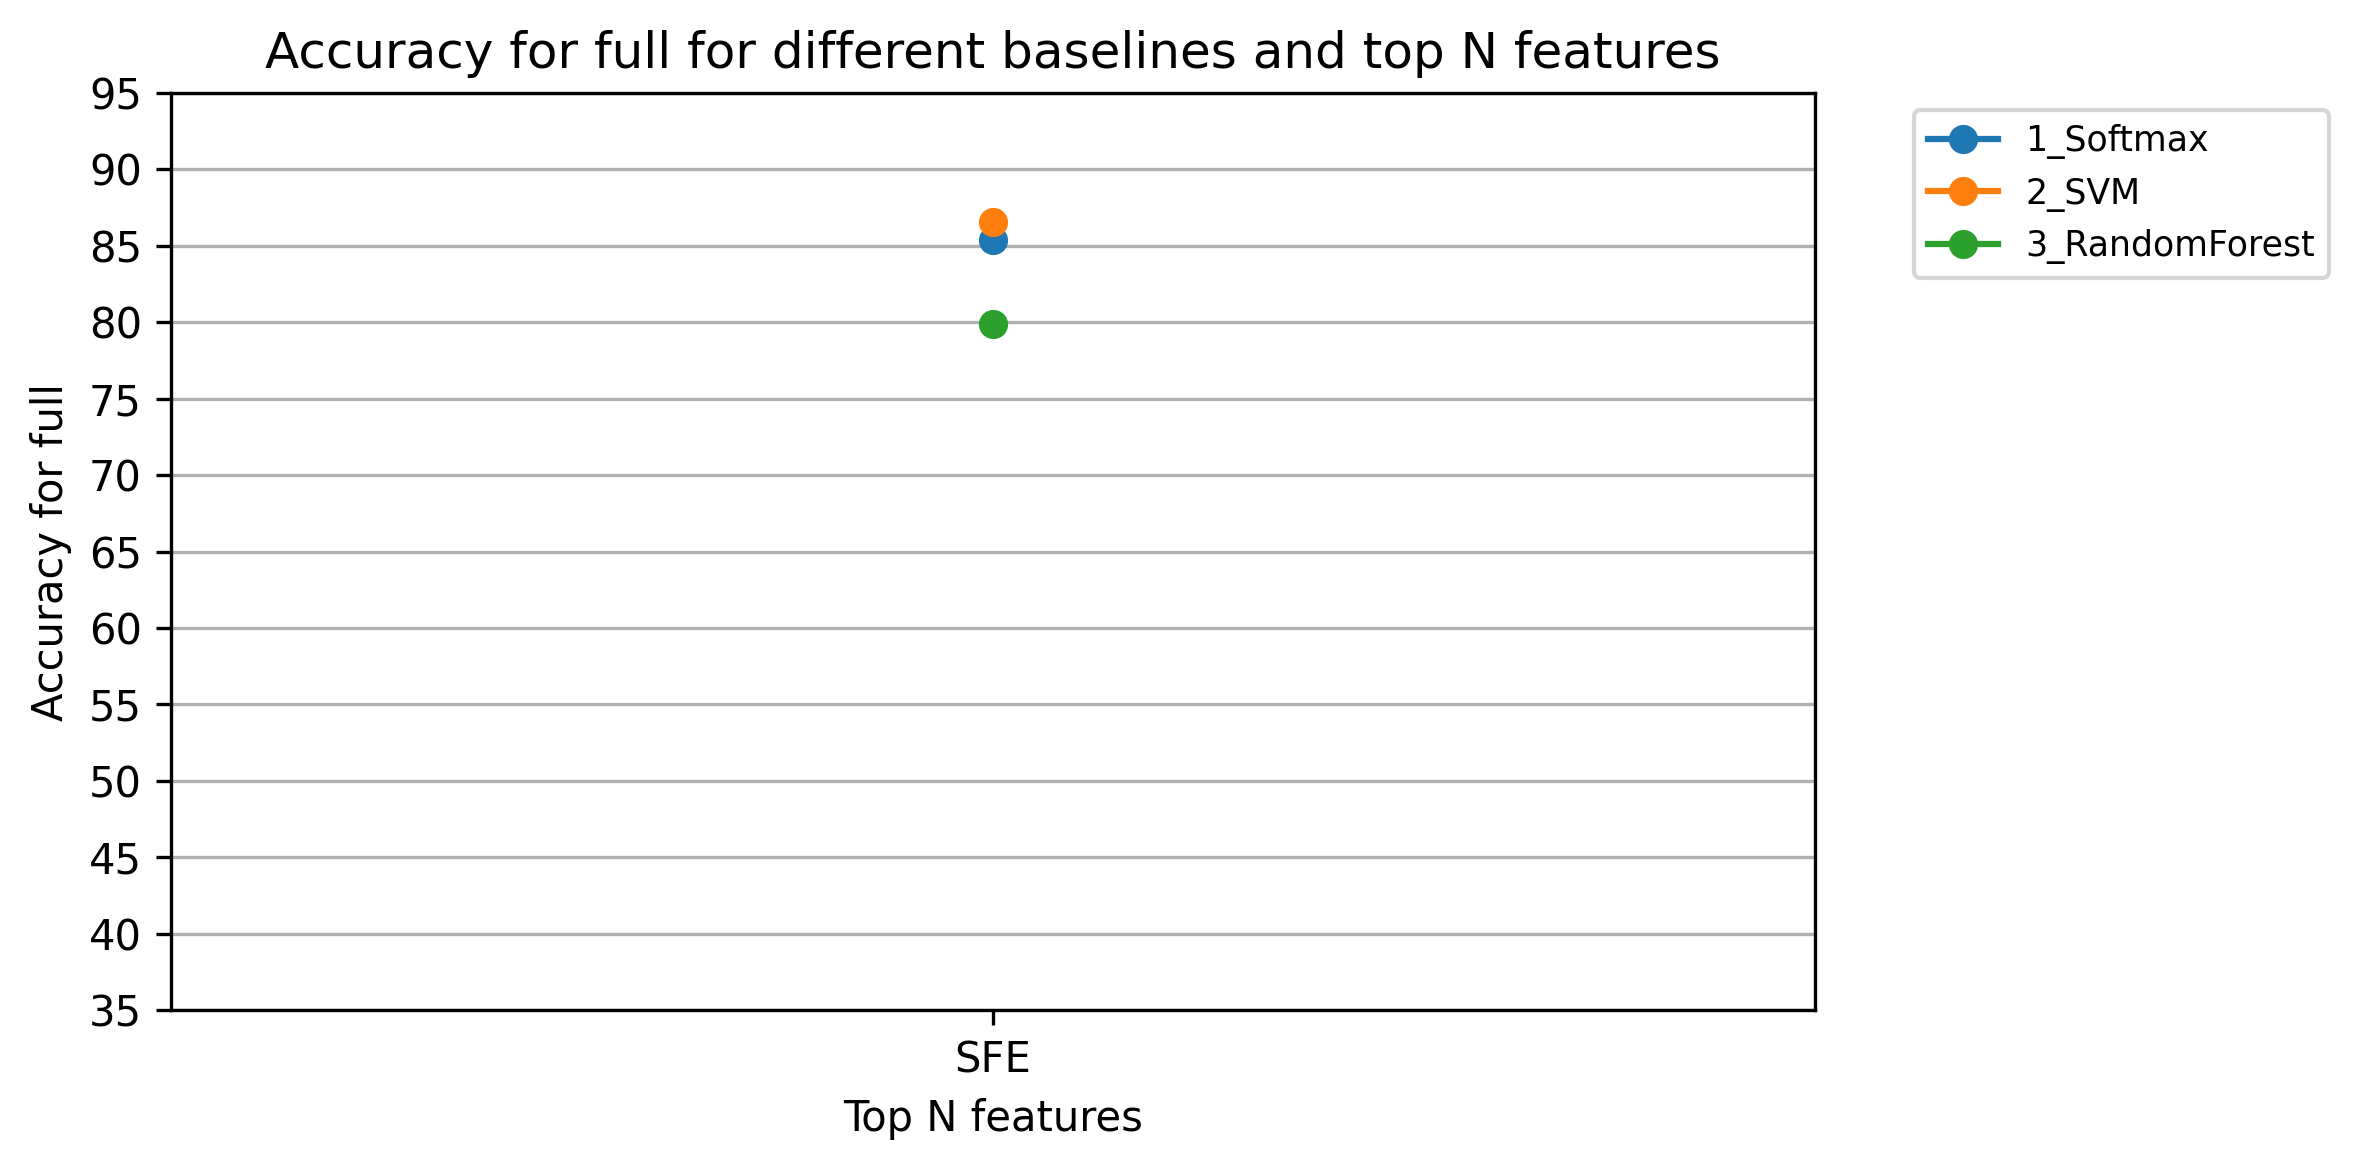

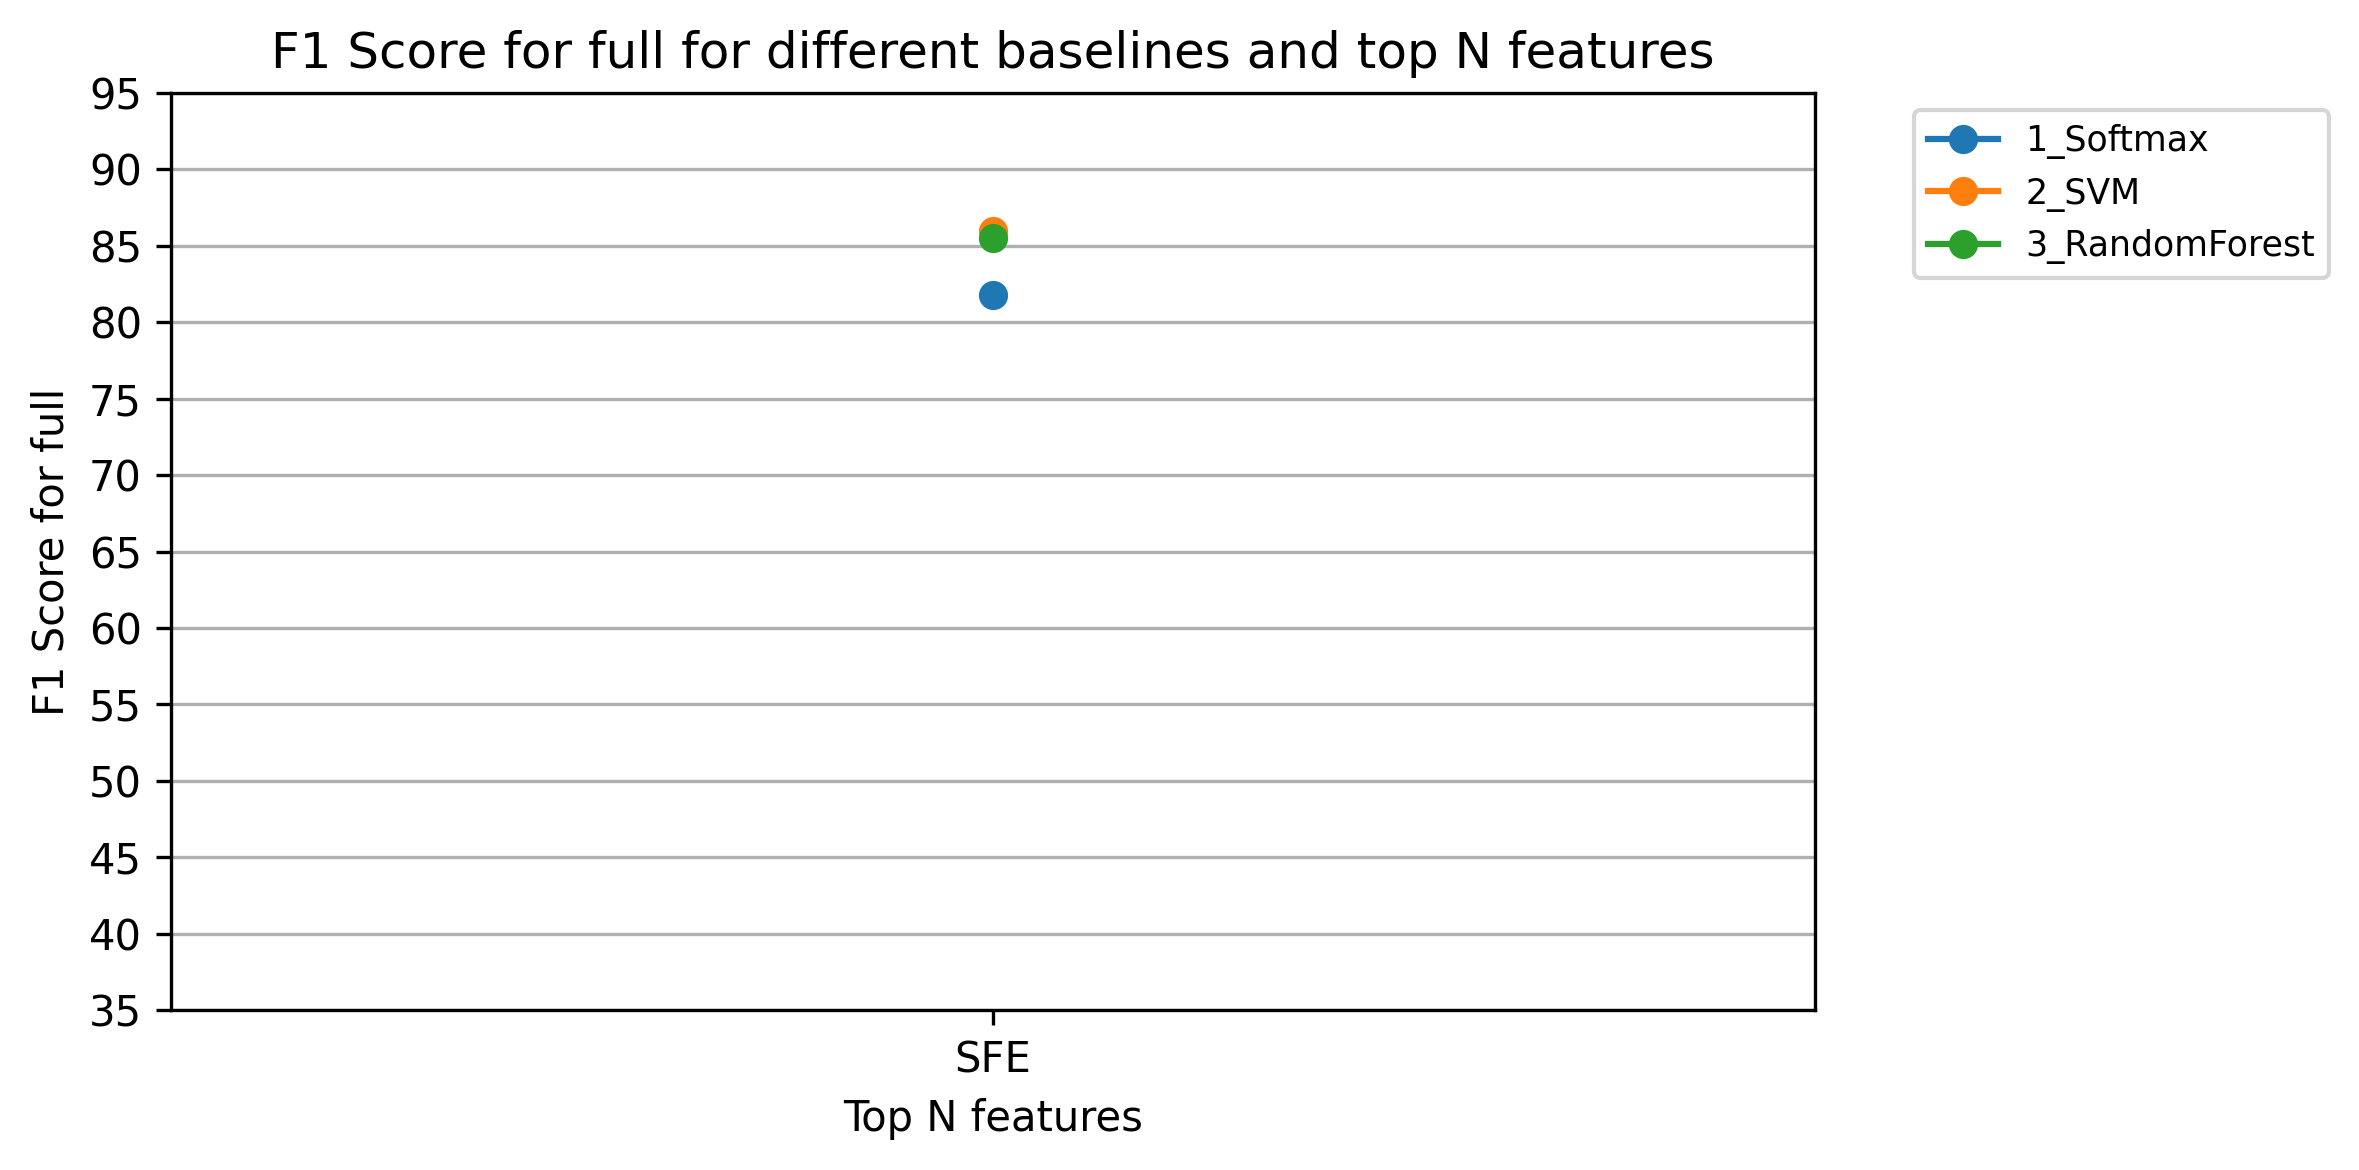

In [33]:
def plot_metrics(metrics, metric_name):
    folder_save_fig = f"/kaggle/working/cmp"
    if not os.path.exists(folder_save_fig):
        os.makedirs(folder_save_fig)
    path_save_fig = f'{folder_save_fig}/{metric_name}.png'
    plt.figure(figsize = (8,4), dpi=300)
    for baseline_name, values in metrics.items():
        top_n_list = [item[0] for item in values]
        metric_values = [item[1] for item in values]
        plt.plot(top_n_list, metric_values, marker='o', label=baseline_name)
    plt.title(f'{metric_name} for different baselines and top N features')
    plt.xlabel('Top N features')
    plt.ylabel(metric_name)
    plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')    
    plt.xticks(top_n_list)
    plt.yticks(list(range(35, 96, 5)))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(path_save_fig, facecolor='white', edgecolor='white')
    plt.show()
    
# Plot accuracy
for model_type in avg_acc_all_models.keys():
    print('*' * 40, model_type, '*' * 40)
    plot_metrics(avg_acc_all_models[model_type], f'Accuracy for {model_type}')
    plot_metrics(avg_f1_all_models[model_type], f'F1 Score for {model_type}')
    print('\n\n')

In [34]:
# Convenient for modifying plot
json_file = "/kaggle/working/results.json"

with open(json_file, mode='w', encoding='utf-8') as file:
    json.dump(filtered_results, file, ensure_ascii=False, indent=4)